# PYPSA China SLide show



In [1]:
%load_ext autoreload
%autoreload 2
%precision %e

'%e'

In [2]:
""" Boiler plate
- import all packages
- emulate snakemake so can load config as usual
- load the network you want
TODO: make it easier to restore old runs
TODO: hide all the boiler pates in a file
"""
%load_ext autoreload
%autoreload 2
%precision %e

import logging
import os.path

# running the jupyter notebook on the compute nodes doesnt build the path as expected, you have to manually do this
import IPython
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pypsa
import seaborn as sns
from IPython.utils import io

working_directory = os.path.dirname(
    IPython.extract_module_locals()[1]["__vsc_ipynb_file__"]
)
workflow_dir = os.path.dirname(working_directory)
scripts_dir = os.path.join(workflow_dir, "scripts")
root_dir = os.path.dirname(workflow_dir)

os.chdir(scripts_dir)


logging.basicConfig(level=logging.CRITICAL)
logger = logging.getLogger(__name__)


# from make_summary import assign_carriers
from _helpers import configure_logging, mock_snakemake

logging.getLogger("plot_network").setLevel(logging.CRITICAL)
logging.getLogger("_plot_utilities").setLevel(logging.CRITICAL)

from _plot_utilities import determine_plottable, fix_network_names_colors
from plot_network import plot_cost_map

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import yaml

REMIND_COUPLED = False
PLANNING_YEAR = 2060
# config = None if not REMIND_COUPLED else "resources/tmp/remind_coupled.yaml"
config = "config/config.yaml" if not REMIND_COUPLED else "resources/tmp/pseudo_coupled.yml"

if config != "":
    with open(os.path.join(root_dir, config)) as f:
        yaml_config = yaml.safe_load(f)
    co2_pathway = yaml_config["scenario"]["co2_pathway"][0]
else:
    co2_pathway = "exp175default"
    config = None

In [4]:
snakemake = mock_snakemake(
    "plot_network",
    snakefile_path=workflow_dir,
    topology="current+FCG", 
    co2_pathway=co2_pathway,
    planning_horizons=PLANNING_YEAR,
    configfiles=config,
    # heating_demand="positive",
)

configure_logging(snakemake, logger=logger)
config = snakemake.config
tech_colors = config["plotting"]["tech_colors"]


ntw_path = snakemake.input.network

print(f"Loading network from {ntw_path}")
n = pypsa.Network(ntw_path)
results_dir = os.path.dirname(os.path.dirname(ntw_path))
weighting = n.snapshot_weightings.iloc[0, 0]

Set parameter WLSAccessID
Set parameter WLSSecret


Set parameter LicenseID to value 946175
WLS license 946175 - registered to Potsdam Institute for Climate Impact Research (PIK)


INFO:__main__:=========== NEW RUN ===========


Loading network from /p/tmp/ivanra/PyPSA-China-clone/PyPSA-China-PIK/results/v-1.3.dev_new_landuse_hr_cheap_nuclear/overnight_co2pw-TEST_REMIND_PKBUDG1000-CHA_topo-current+FCG/postnetworks/ntwk_2060_IM2XJ4.nc


### Fix network for plotting // add missing info

In [5]:
fix_network_names_colors(n, config)
determine_plottable(n);

/p/tmp/ivanra/PyPSA-China-clone/PyPSA-China-PIK/workflow/scripts/_plot_utilities.py:301: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





# Plot maps

### plot capex

In [6]:
from _plot_utilities import set_plot_style
from plot_network import plot_energy_map

set_plot_style(
    style_config_file=os.path.abspath(
        "../../config/plotting_styles/network_map.mplstyle"
    ),
    base_styles=["classic", "seaborn-v0_8-white"],
)

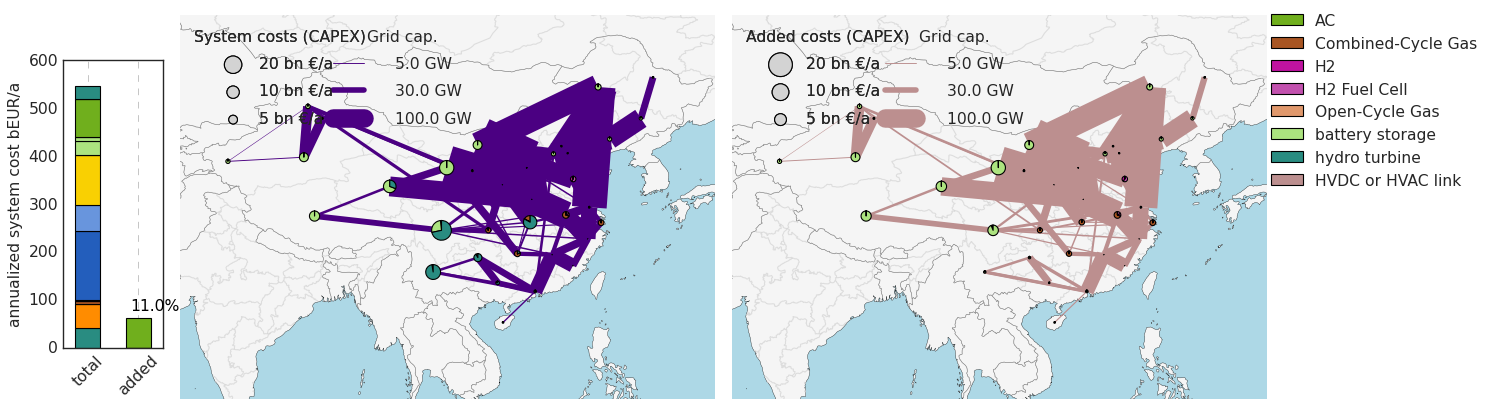

In [7]:
with io.capture_output() as captured:
    ax = plot_cost_map(n, config["plotting"], cost_pannel=True, capex_only=True)

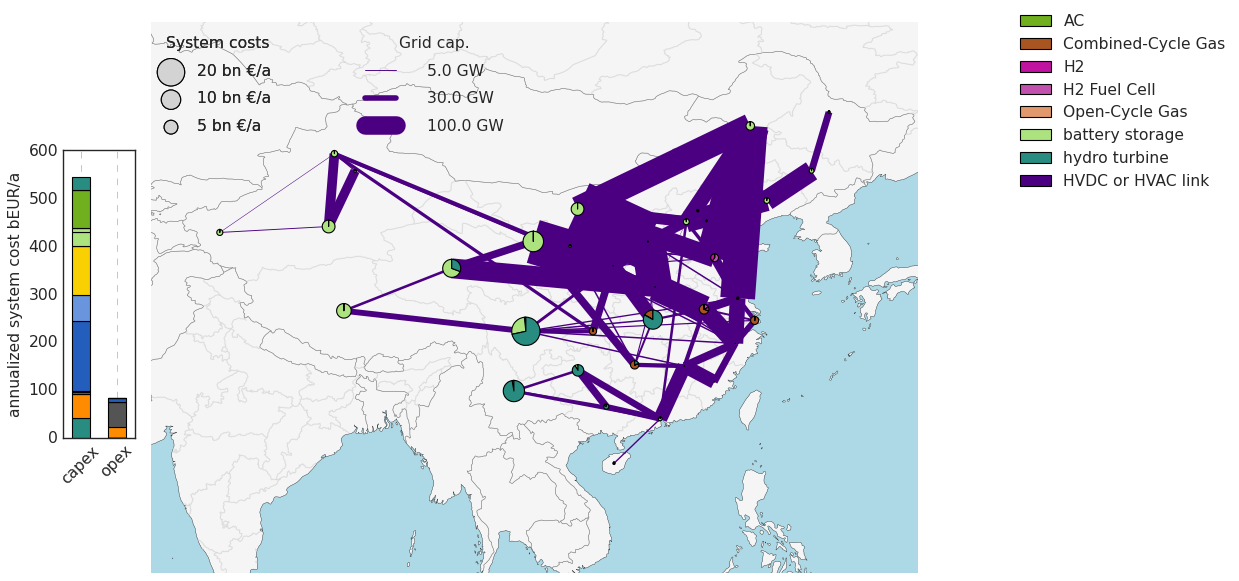

In [8]:
# TODO fix layout
with io.capture_output() as captured:
    ax = plot_cost_map(
        n, config["plotting"], cost_pannel=True, plot_additions=False, capex_only=False
    )

## plot electricy generation map

In [9]:
import glob
import re
from PIL import Image

# Recursively search for files matching 'ntwk.png' in 'plots/networks/' under results_dir

matches = sorted(glob.glob(f"{results_dir}/plots/networks/*el_supply.png", recursive=True))
# Load all images from the matched file paths
images = [Image.open(match) for match in matches]

# Save as GIF (animated)
if images:
    gif_path = f"{results_dir}/plots/networks/el_supply.gif"
    images[0].save(
        gif_path,
        save_all=True,
        append_images=images[1:],
        duration=500,  # duration per frame in ms
        loop=0
    )
    print(f"GIF saved to {gif_path}")
else:
    print("No images found to create GIF.")

GIF saved to /p/tmp/ivanra/PyPSA-China-clone/PyPSA-China-PIK/results/v-1.3.dev_new_landuse_hr_cheap_nuclear/overnight_co2pw-TEST_REMIND_PKBUDG1000-CHA_topo-current+FCG/plots/networks/el_supply.gif


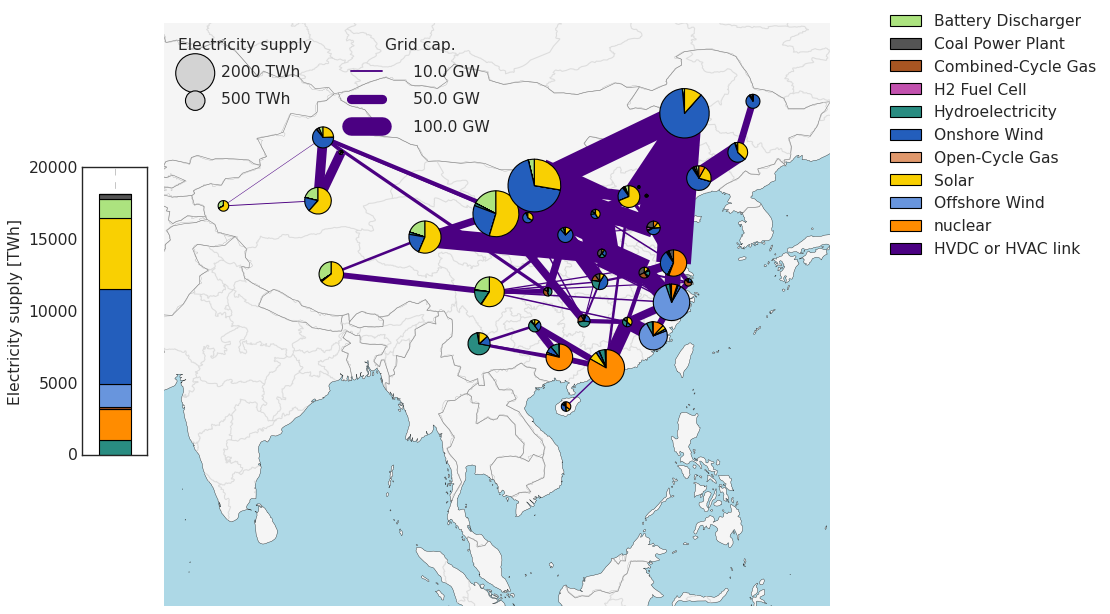

In [10]:
from IPython.utils import io

with io.capture_output() as captured:
    plot_energy_map(
        n, config["plotting"], carrier="AC", components=["Generator", "Link"]
    )

In [11]:
from _plot_utilities import set_plot_style
from plot_network import plot_energy_map

if snakemake.config["heat_coupling"]:
    set_plot_style(
        style_config_file=os.path.abspath(
            "../../config/plotting_styles/network_map.mplstyle"
        ),
        # snakemake.config["plotting"]["network_style_config_file"],
        base_styles=["classic", "seaborn-v0_8-white"],
    )
    plot_energy_map(
        n, config["plotting"], carrier="heat", components=["Generator", "Link"]
    )

## Nodal prices

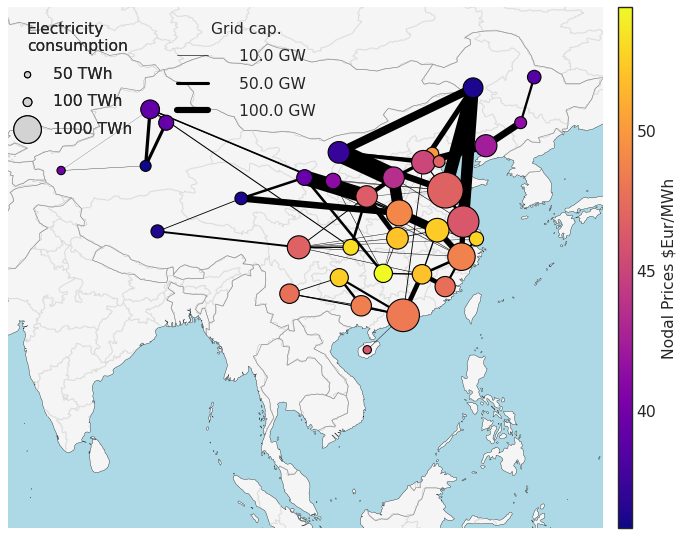

In [12]:
from plot_network import plot_nodal_prices

with io.capture_output() as captured:
    plot_nodal_prices(n, config["plotting"], "AC")

# CO2 emissions & Stores


In [13]:
n.global_constraints

,type,investment_period,carrier_attribute,sense,constant,mu,mu_lc_limit
GlobalConstraint,,,,,,,
lc_limit,transmission_expansion_cost_limit,NaN,"AC, DC",<=,2.500561e+11,-7.472296e-08,-7.472296e-08


In [14]:
PLOT_EMISSIONS = False
if PLOT_EMISSIONS:
    gen_emissions = (
        (
            (n.generators_t.p / n.generators.efficiency)
            * n.generators.carrier.map(n.carriers.co2_emissions)
        )
        .T.groupby(n.generators.carrier)
        .sum()
        .T.cumsum()
    )
    fig, ax = plt.subplots()
    gen_emissions.where(gen_emissions >= 0).dropna(axis=1, how="all").plot(ax=ax)
    ax.set_ylabel("cum CO2 emissions [t]")

In [15]:
CHECK_STORES = False
if CHECK_STORES:
    battery_stores = n.stores[n.stores.carrier.str.contains("battery")]
    battery_stores_t = n.stores_t.e[
        n.stores_t.e.columns.intersection(battery_stores.index)
    ]
    battery_stores_t.sum(axis=1).plot()

    gas_stores = n.stores[n.stores.carrier.str.contains("gas")]
    gas_stores_t = n.stores_t.e[n.stores_t.e.columns.intersection(gas_stores.index)]
    gas_stores_t.sum(axis=1).plot()

## Stores & CO2 capture
! beware the store is the difference :)

In [16]:
try:
    stores = n.stores_t.e.T.groupby(n.stores.carrier).sum()
    diff = stores.iloc[:, -1] - stores.iloc[:, 0]
    co2_cap = stores.iloc[:, -1].loc[["CO2 capture"]].sum()
    co2_cap
except KeyError:
    print("Overnight model does not have CO2 capture or biomass stores, skipped")

Overnight model does not have CO2 capture or biomass stores, skipped


Text(0, 0.5, 'Stored Energy [MWh]')

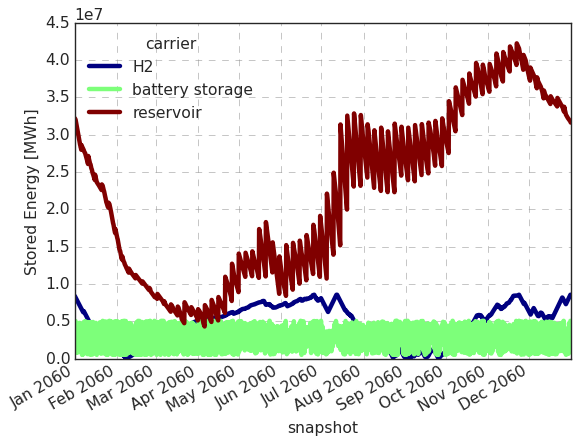

In [17]:
ax = n.stores_t.e.T.groupby(n.stores.carrier).sum().drop("gas").T.plot(lw=4, cmap="jet")
ax.set_ylabel("Stored Energy [MWh]")

# Time series

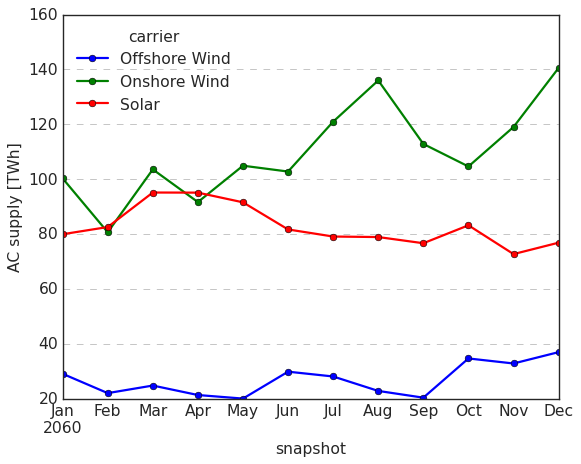

In [18]:
mnthly_supp = n.statistics.supply(
    comps=["Generator", "Link"], bus_carrier="AC", aggregate_time=False
).query("carrier in ['Solar', 'Onshore Wind', 'Offshore Wind']")
mnthly_supp = mnthly_supp.T.droplevel(0, axis=1) / 1e6
mnthly_supp.index = mnthly_supp.index.astype("datetime64[ns]")
ax = mnthly_supp.resample("ME").sum().plot(marker="o")
ax.set_ylabel("AC supply [TWh]");

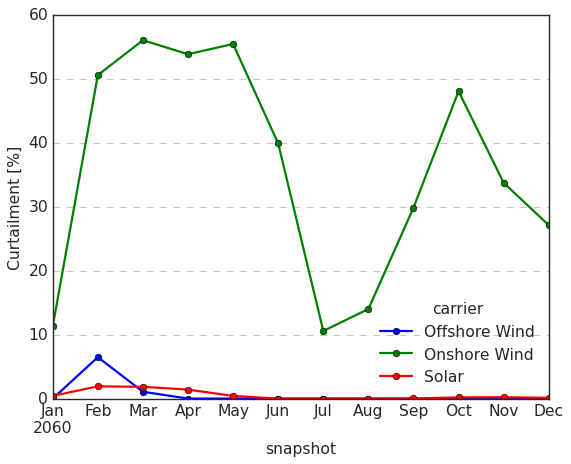

In [19]:
mnthly_curt = n.statistics.curtailment(
    comps=["Generator", "Link"], bus_carrier="AC", aggregate_time=False
).query("carrier in ['Solar', 'Onshore Wind', 'Offshore Wind']")
supply = n.statistics.supply(
    comps=["Generator"], bus_carrier="AC", aggregate_time=False
).query("carrier in ['Solar', 'Onshore Wind', 'Offshore Wind']")
mnthly_curt = mnthly_curt.T.droplevel(0, axis=1)
supply = supply.droplevel(0).T
mnthly_curt.index = mnthly_curt.index.astype("datetime64[ns]")
curtail_pc = (
    100
    * mnthly_curt.resample("ME").sum()
    / (supply.resample("ME").sum() + mnthly_curt.resample("ME").sum())
)
ax = curtail_pc.plot(marker="o")
ax.set_ylabel("Curtailment [%]");

In [20]:
PLOT_DEMAND_PROFILES = False
PLOT_PRICES = True

In [21]:
if PLOT_DEMAND_PROFILES:
    reg_groups = pd.read_csv(
        os.path.join(root_dir, "resources/data/regions/province_grid_groups.csv")
    )
    reg_groups.set_index("Province", inplace=True)
    mapper = reg_groups["Region"].to_dict()
    grid_demands = (
        n.statistics.withdrawal(
            comps="Load", groupby=["location"], bus_carrier="AC", aggregate_time=False
        )
        .groupby(mapper)
        .sum()
    )
    mnthly_grid_demands = grid_demands.T.resample("ME").sum()
    mnthly_grid_demands_normalized = mnthly_grid_demands / mnthly_grid_demands.sum()
    ax = mnthly_grid_demands_normalized.plot(lw=2)
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Region")
    # ax.set_ylim([0, mnthly_grid_demands.max().max()*1.1])
    ax.set_ylabel("Normalized AC Monthly Demand [MWh]")

    order = mnthly_grid_demands.sum().sort_values(ascending=False).index
    ax2 = mnthly_grid_demands[order].plot.area(cmap="magma")
    ax2.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Grid")
    ax2.set_ylim([0, mnthly_grid_demands.T.sum().max() * 1.1])
    ax2.set_ylabel("AC Monthly Demand [MWh]")

    load_ac = (
        n.statistics.withdrawal(
            comps="Load", bus_carrier="AC", aggregate_time=False, groupby=["location"]
        )
        .T.resample("M")
        .sum()
    )
    order = load_ac.sum().sort_values(ascending=False).index

    ax = load_ac[order].plot.area(cmap="magma")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Province", ncols=2)
    ax.set_ylabel("Demand [MWh]")

In [22]:
if PLOT_DEMAND_PROFILES:
    monthly_withdrawal = (
        n.statistics.withdrawal(comps="Load", bus_carrier="AC", aggregate_time=False)
        .T.resample("M")
        .sum()
    )
    monthly_withdrawal.index = monthly_withdrawal.index.month
    monthly_withdrawal.plot.bar()
    plt.xlabel("Month")
    plt.ylabel("Monthly Withdrawal [MWh]")
    plt.title(f"Monthly Electricity Withdrawal ({year})")
    plt.xticks(
        ticks=range(0, 12),
        labels=[
            "Jan",
            "Feb",
            "Mar",
            "Apr",
            "May",
            "Jun",
            "Jul",
            "Aug",
            "Sep",
            "Oct",
            "Nov",
            "Dec",
        ],
    )
    plt.tight_layout()

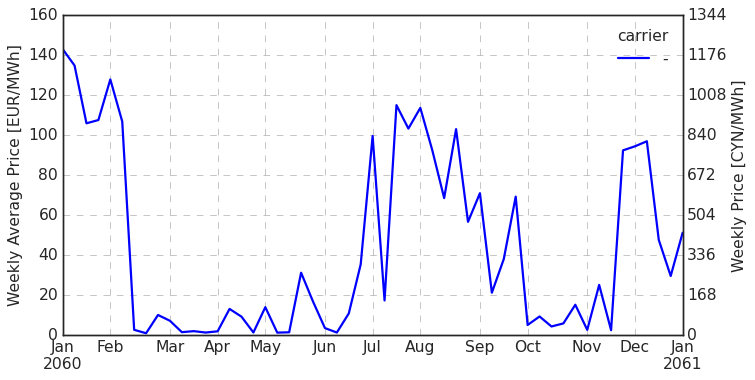

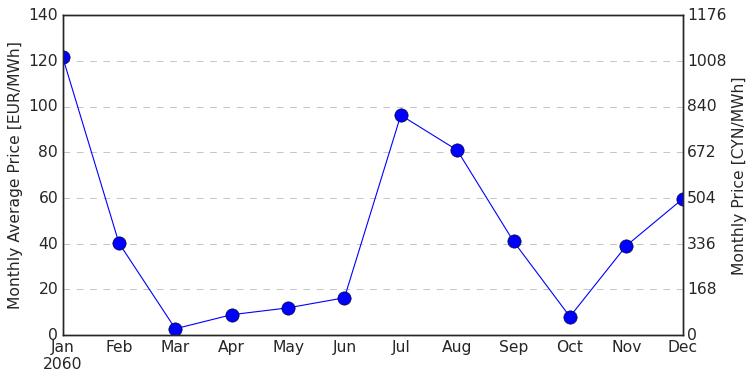

In [23]:
if PLOT_PRICES:
    rev = n.statistics.revenue(comps="Load", bus_carrier="AC", aggregate_time=False)
    supply = n.statistics.withdrawal(
        comps="Load", bus_carrier="AC", aggregate_time=False
    )
    prices_w = -1 * rev.T.resample("W").sum() / supply.T.resample("W").sum()

    fig, ax = plt.subplots(figsize=(10, 5))
    ax2 = ax.twinx()
    prices_w.plot(label=None, ax=ax)
    ax.set_ylabel("Weekly Average Price [EUR/MWh]")
    EUR2CYN = 8.4
    ax.set_yticks(ax.get_yticks())
    ax2.yaxis.set_ticks_position("right")
    ax2.set_ylabel("Weekly Price [CYN/MWh]")
    ax2.set_ylim([v * EUR2CYN for v in ax.get_ylim()])
    # Set y-ticks for both axes explicitly
    ax2.set_yticks([v * EUR2CYN for v in ax.get_yticks()])
    ax2.grid(None)
    ax.set_xlabel("")

    fig, ax = plt.subplots(figsize=(10, 5))
    ax2 = ax.twinx()
    prices_m = -1 * rev.T.resample("ME").sum() / supply.T.resample("ME").sum()
    prices_m.plot(label=None, ax=ax, lw=1, marker="o", markersize=12, legend=False)
    ax.set_ylabel("Monthly Average Price [EUR/MWh]")
    EUR2CYN = 8.4
    ax.set_yticks(ax.get_yticks())
    ax2.yaxis.set_ticks_position("right")
    ax2.set_ylabel("Monthly Price [CYN/MWh]")
    ax2.set_ylim([v * EUR2CYN for v in ax.get_ylim()])
    # Set y-ticks for both axes explicitly
    ax2.set_yticks([v * EUR2CYN for v in ax.get_yticks()])
    ax2.grid(None)
    ax.set_xlabel("")

    most_expensive_week = [
        prices_w.idxmax().iloc[0] - pd.Timedelta(days=3.5),
        prices_w.idxmax().iloc[0] + pd.Timedelta(days=3.5),
    ]

## Weekly energy balances

In [24]:
from plot_time_series import plot_energy_balance

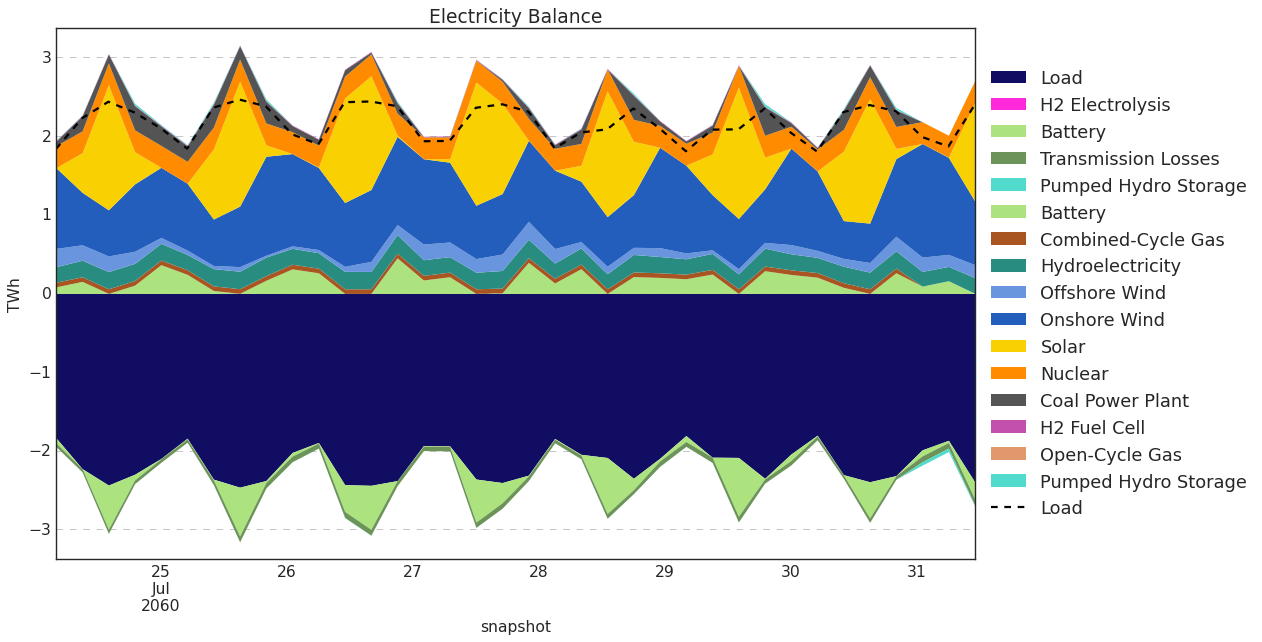

In [25]:
with io.capture_output() as captured:
    ax = plot_energy_balance(
        n,
        config["plotting"],
        start_date=f"{PLANNING_YEAR}-07-24 00:00",
        end_date=f"{PLANNING_YEAR}-07-31 12:00:00",
    )
    ax.grid(axis="y")
    ax.set_title("Electricity Balance")

In [26]:
PLOT_SUPPLY = 1E3
start_date="2060-03-31 21:00"
end_date="2060-04-06 12:00:00"
plot_config = config["plotting"]
p = (
    n.statistics.energy_balance(aggregate_time=False, bus_carrier="AC")
    .dropna(how="all")
    .groupby("carrier")
    .sum()
    .div(PLOT_SUPPLY)
    # .drop("-")
    .T
)

p = p.loc[start_date:end_date]
p.rename(columns={"-": "Load", "AC": "transmission losses"}, inplace=True)


extra_c = {
    "Load": plot_config["tech_colors"]["electric load"],
    "transmission losses": plot_config["tech_colors"]["transmission losses"],
}
# colors & names part 1
p.rename(plot_config["nice_names"], inplace=True)
p.rename(columns={k: k.title() for k in p.columns}, inplace=True)
# split into supply and wothdrawal
supply = p.where(p > 0).dropna(axis=1, how="all")
charge = p.where(p < 0).dropna(how="all", axis=1)

# fix names and order

charge.rename(columns={"Battery Storage": "Battery"}, inplace=True)
supply.rename(columns={"Battery Discharger": "Battery"}, inplace=True)


preferred_order = plot_config["preferred_order"]
plot_order = (
    supply.columns.intersection(preferred_order).to_list()
    + supply.columns.difference(preferred_order).to_list()
)

plot_order_charge = [name for name in preferred_order if name in charge.columns] + [
    name for name in charge.columns if name not in preferred_order
]

supply = supply.reindex(columns=plot_order)

In [27]:
curtailed = n.statistics.curtailment(aggregate_time=False, bus_carrier="AC").droplevel(0).div(PLOT_SUPPLY)
opt_cap = n.statistics.optimal_capacity(comps = ["Generator", "Link"], bus_carrier="AC").droplevel(0).div(PLOT_SUPPLY)
opt_cap.clip(lower=0, inplace=True) # remove consumers
opt_cap.drop(["Solar", "Offshore Wind", "Onshore Wind", "AC"], inplace=True)
missing = list(set(opt_cap.index).difference(curtailed.index))
supply.rename(columns={"H2 Turbine": "H2 turbine"}, inplace=True)
supply_vre = n.statistics.supply(comps=["Generator"], bus_carrier="AC", aggregate_time=False).droplevel(0).T.div(PLOT_SUPPLY)[["Solar", "Offshore Wind", "Onshore Wind"]]

reserve = opt_cap[[x for x in missing if x in supply.columns]] - supply[[x for x in missing if x in supply.columns]]
reserve=pd.concat([curtailed.T, reserve], axis=1).fillna(0)
load = n.statistics.withdrawal(comps="Load", bus_carrier="AC", aggregate_time=False).T.div(PLOT_SUPPLY)

In [28]:
optc = n.statistics.optimal_capacity(comps = ["Generator", "Link"], bus_carrier="AC").clip(0).droplevel(0).div(PLOT_SUPPLY)
optc.drop(["Solar", "Offshore Wind", "Onshore Wind", "AC"], inplace=True)
res_ = optc.sum()-load["-"] + supply_vre.T.sum() + curtailed.sum()
res_

snapshot
2060-01-01 00:00:00    3087.066601
2060-01-01 05:00:00    3058.031399
2060-01-01 10:00:00    3289.779092
2060-01-01 15:00:00    4355.545356
2060-01-01 20:00:00    2018.492534
                          ...     
2060-12-30 23:00:00    4385.161045
2060-12-31 04:00:00    4574.011897
2060-12-31 09:00:00    4514.492629
2060-12-31 14:00:00    6470.425684
2060-12-31 19:00:00    3939.750503
Length: 1752, dtype: float64

/home/ivanra/.conda/envs/pypsa-china/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1800: UserWarning:

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.



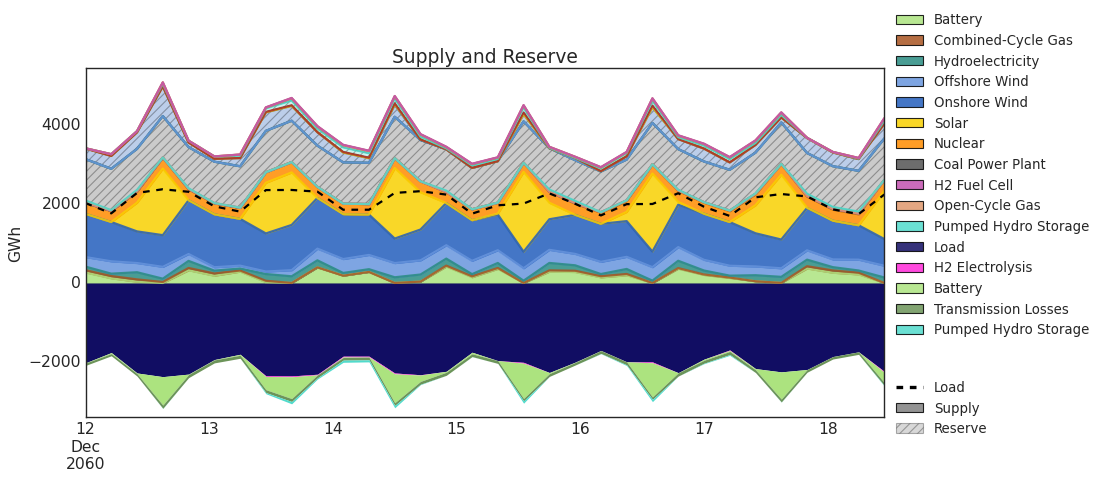

In [29]:
PLOT_SUPPLY_LABEL = "GWh"
NAN_COLOR = "brown"
from _plot_utilities import make_nice_tech_colors, get_stat_colors
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

def plot_reserves(
    n: pypsa.Network,
    plot_config: dict,
    start_date="2060-03-31 21:00",
    end_date="2060-04-06 12:00:00",
    aggregate_fossil=False,
    add_load_line=True,
    ax: plt.Axes = None,
    hatch = '///'
):
    """plot the electricity balance of the network for the given time range

    Args:
        n (pypsa.Network): the network
        plot_config (dict): the plotting config (snakemake.config["plotting"])
        bus_carrier (str, optional): the carrier for the energy_balance op. Defaults to "AC".
        start_date (str, optional): the range to plot. Defaults to "2060-03-31 21:00".
        end_date (str, optional): the range to plot. Defaults to "2060-04-06 12:00:00".
        aggregate_fossil (bool, optional): whether to aggregate fossil fuels. Defaults to False.
        add_load_line (bool, optional): add a dashed line for the load. Defaults to True.
    """
    if not ax:
        fig, ax = plt.subplots(figsize=(12, 12))
    else:
        fig = ax.get_figure()
    bus_carrier = "AC"
    p = (
        n.statistics.energy_balance(aggregate_time=False, bus_carrier=bus_carrier)
        .dropna(how="all")
        .groupby("carrier")
        .sum()
        .div(PLOT_SUPPLY)
        # .drop("-")
        .T
    )

    p = p.loc[start_date:end_date]
    p.rename(columns={"-": "Load", "AC": "transmission losses"}, inplace=True)

    # aggreg fossil
    if aggregate_fossil:
        coal = p.filter(regex="[C|c]oal")
        p.drop(columns=coal.columns, inplace=True)
        p["Coal"] = coal.sum(axis=1)
        gas = p.filter(regex="[G|g]as")
        p.drop(columns=gas.columns, inplace=True)
        p["Gas"] = gas.sum(axis=1)

    extra_c = {
        "Load": plot_config["tech_colors"]["electric load"],
        "transmission losses": plot_config["tech_colors"]["transmission losses"],
    }
    nice_tech_colors = make_nice_tech_colors(plot_config["tech_colors"], plot_config["nice_names"])
    color_series = get_stat_colors(n, nice_tech_colors, extra_colors=extra_c)
    # color_series.rename({"H2 Turbine": "H2 turbine"}, inplace=True)
    # colors & names part 1
    p.rename(plot_config["nice_names"], inplace=True)
    p.rename(columns={k: k.title() for k in p.columns}, inplace=True)
    color_series.index = color_series.index.str.strip()
    # split into supply and wothdrawal
    supply = p.where(p > 0).dropna(axis=1, how="all")
    charge = p.where(p < 0).dropna(how="all", axis=1)

    # fix names and order
    charge.rename(columns={"Battery Storage": "Battery"}, inplace=True)
    supply.rename(columns={"Battery Discharger": "Battery"}, inplace=True)
    color_series = color_series[charge.columns.union(supply.columns)]
    color_series.rename(
        {"Battery Discharger": "Battery", "Battery Storage": "Battery",},
        inplace=True,
    )
    # Deduplicate color_series
    color_series = color_series[~color_series.index.duplicated(keep="first")]
    color_series.index = color_series.index.str.title()

    preferred_order = plot_config["preferred_order"]
    plot_order = (
        supply.columns.intersection(preferred_order).to_list()
        + supply.columns.difference(preferred_order).to_list()
    )

    plot_order_charge = [name for name in preferred_order if name in charge.columns] + [
        name for name in charge.columns if name not in preferred_order
    ]
    supply = supply.reindex(columns=plot_order)

    curtailed = n.statistics.curtailment(aggregate_time=False, bus_carrier="AC").droplevel(0).div(PLOT_SUPPLY)
    opt_cap = n.statistics.optimal_capacity(comps = ["Generator", "Link"], bus_carrier="AC").droplevel(0).div(PLOT_SUPPLY)
    opt_cap.drop("AC", inplace=True)
    missing = list(set(opt_cap.index).difference(curtailed.index))
   
    reserve = opt_cap[[x for x in missing if x in supply.columns]] - supply[[x for x in missing if x in supply.columns]]
    reserve=pd.concat([curtailed.T, reserve], axis=1)

    # build reserves and supply
    common_index = reserve.index.intersection(supply.index)
    supply_plot = supply.loc[common_index, :]
    reserve_plot = reserve.loc[common_index, :]
    stacked_df = pd.concat([supply_plot, reserve_plot], axis=1, keys=['Supply', 'Reserve'])
    # Flatten columns for plotting
    stacked_df.columns = [f"{grp} {col}" for grp, col in stacked_df.columns]
 
    sequence = [c.replace("Supply ","").replace("Reserve ","") for c in stacked_df.columns]
    colors_ = [color_series[c] if c in color_series.index else NAN_COLOR for c in sequence ]
    alpha_supply = 0.85
    stacked_df.plot.area(stacked=True, figsize=(14,6), alpha=alpha_supply, ax = ax, color=colors_)
    ax.set_title('Supply and Reserve')

    charge = charge.reindex(columns=plot_order_charge)

    if not charge.empty:
        charge.plot.area(ax=ax, linewidth=0, color=color_series.loc[charge.columns])

    if add_load_line:

        charge["load_pos"] = charge["Load"] * -1
        charge["load_pos"].plot(linewidth=2, color="black", label="Load", ax=ax, linestyle="--")
        charge.drop(columns="load_pos", inplace=True)

    # ax.legend(ncol=1, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, fontsize=16)
    ax.set_ylabel(PLOT_SUPPLY_LABEL)
    ax.set_ylim(charge.sum(axis=1).min() * 1.07, stacked_df.sum(axis=1).max() * 1.07)
    ax.grid(axis="y")
    ax.set_xlim(supply.index.min(), supply.index.max())
    ax.set_xlabel("")

    # Make reserve semi-transparent
    alpha_reserve = 0.3
    # Simplify legend: only show supply blocks, add custom patches for supply and reserve
    handles = []
    # Do not add reserve columns to legend
    for col in stacked_df.columns:
        if not col.startswith('Reserve'):
            color = ax.collections[stacked_df.columns.get_loc(col) ].get_facecolor()[0]
            handles.append(Patch(facecolor=color, alpha=alpha_supply, label=col.replace('Supply ', '')))
    for col in charge.columns:
            # Find the corresponding color in the ax.collections
        offset = len(ax.collections) - len(charge.columns)
        color = ax.collections[charge.columns.get_loc(col)+offset].get_facecolor()[0]
        handles.append(Patch(facecolor=color, alpha=alpha_supply, label=col))

    for i, col in enumerate(stacked_df.columns):
        if col.startswith('Reserve'):
            ax.collections[i].set_alpha(alpha_reserve)
            ax.collections[i].set_hatch(hatch)
            ax.collections[i].set_edgecolor('k')

    # Add custom patches for supply and reserve
    handles.append(Patch(facecolor='white', edgecolor="white", alpha=0, label='\n'))
    handles.append(Line2D([0], [0], color='black', linewidth=3, linestyle='--', label='Load'))
    handles.append(Patch(facecolor='grey', alpha=alpha_supply, label='Supply'))
    handles.append(Patch(facecolor='grey', alpha=alpha_reserve, label='Reserve', hatch=hatch))
    handles.append(Patch(edgecolor="white", alpha=0, label='\n'))
    ax.legend(handles=handles, ncol=1, loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, fontsize=12)


    fig.tight_layout()

    return ax

ax  = plot_reserves(n, config["plotting"],add_load_line=True, start_date=f"{PLANNING_YEAR}-12-11 21:00", end_date=f"{PLANNING_YEAR}-12-18 12:00:00")

In [30]:
load = n.statistics.withdrawal(comps="Load", bus_carrier="AC", aggregate_time=False).T


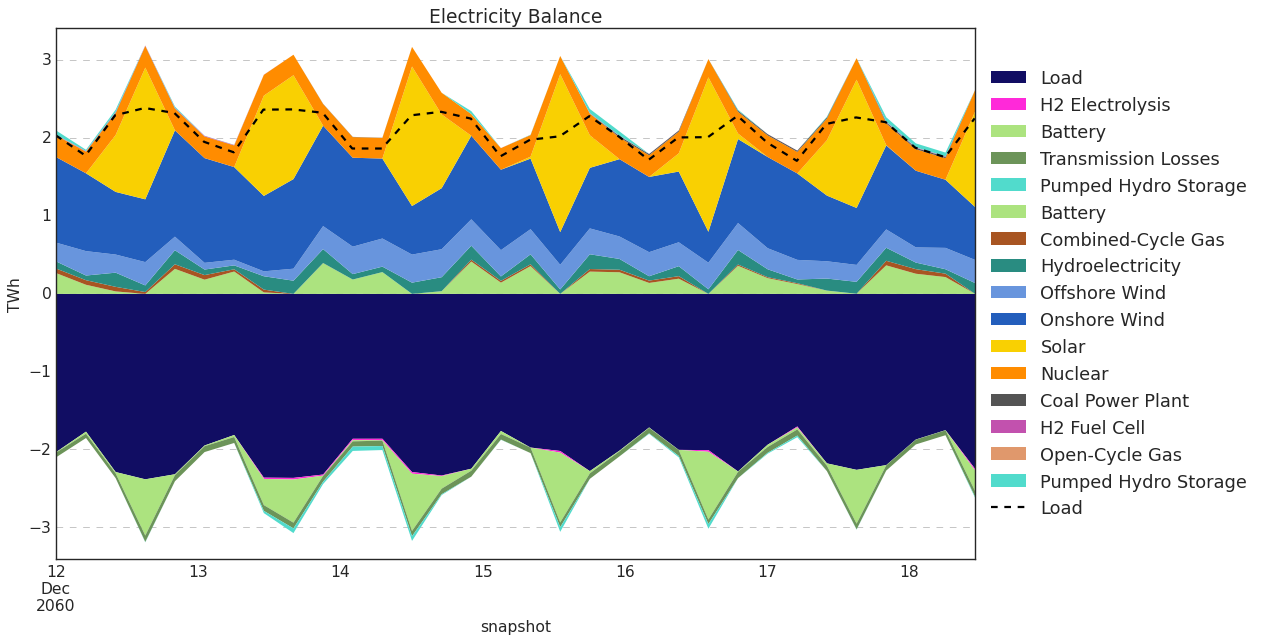

In [31]:
with io.capture_output() as captured:
    ax = plot_energy_balance(
        n,
        config["plotting"],
        start_date=f"{PLANNING_YEAR}-12-11 21:00",
        end_date=f"{PLANNING_YEAR}-12-18 12:00:00",
    )
    ax.grid(axis="y")
    ax.set_title("Electricity Balance")

## price series

In [74]:
# from constants import PROV_NAMES
# marginal_price_series = n.buses_t["marginal_price"][PROVINCE_NODE_MAP]
# prov_max_price_series = marginal_price_series.T.max()
# prov_min_price_series = marginal_price_series.T.min()
# spread = marginal_price_series.T.max()-marginal_price_series.T.min()
# load_ac = n.statistics.withdrawal(bus_carrier="AC", aggregate_time=False, groupby="location", comps = "Load")

# regional_weighed_price = marginal_price_series.T.mul(load_ac).T.sum()/load_ac.T.sum()
# order =regional_weighed_price.sort_values().index

# weighed_prices = (marginal_price_series.T.mul(load_ac)/load_ac.sum()).sum()
# ax = marginal_price_series[order].plot(alpha=0.5, lw=2, legend=False, cmap="plasma")
# weighed_prices.plot(ax = ax, lw=3, c="black", label = "weighted price avg", alpha =0.8, ls = "--")
# ax.legend(  loc='upper left', bbox_to_anchor=(1, 1), ncols=2);

In [75]:
PROVINCE_NODE_MAP = n.buses.query("carrier=='AC'").province


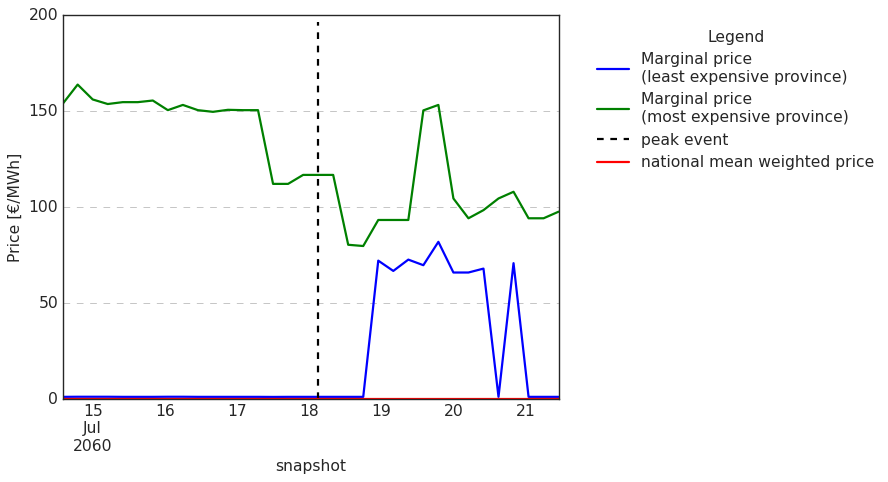

In [95]:
from _plot_utilities import find_weeks_of_interest
from constants import PROV_NAMES

winter_week, summer_week = find_weeks_of_interest(
    n, f"{PLANNING_YEAR}-04-01", f"{PLANNING_YEAR}-10-06"
)
marginal_price_series = n.buses_t["marginal_price"][PROVINCE_NODE_MAP.index]
prov_max_price_series = marginal_price_series.T.max()
prov_min_price_series = marginal_price_series.T.min()
spread = marginal_price_series.T.max() - marginal_price_series.T.min()
load_ac = n.statistics.withdrawal(
    bus_carrier="AC", aggregate_time=False, groupby="location", comps="Load"
)
weighed_prices = (marginal_price_series.T.mul(load_ac) / load_ac.sum()).sum()


ax = prov_min_price_series.loc[summer_week].plot(
    label="Marginal price\n(least expensive province)"
)
prov_max_price_series.loc[summer_week].plot(
    label="Marginal price\n(most expensive province)", ax=ax
)
# spread.loc[summer_week].plot(label = "Price spread", ax =ax, ls= "--")
ax.set_ylabel("Price [€/MWh]")
# ax.vlines(winter_week[len(winter_week)//2], 0,prov_max_price_series.max()*1.2, color="black", ls = "--", label="peak event")
ax.vlines(
    summer_week[len(summer_week) // 2],
    0,
    prov_max_price_series.loc[summer_week].max() * 1.2,
    color="black",
    ls="--",
    label="peak event",
)

weighed_prices.loc[summer_week].plot(ax=ax, label="national mean weighted price")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Legend")


## Prices - balance overlay

In [96]:
peak_pr_provinces_hrs_winter = pd.concat(
    [
        marginal_price_series.loc[winter_week].T.idxmax(),
        marginal_price_series.loc[winter_week].T.max(),
    ],
    axis=1,
)
peak_pr_provinces_hrs_summer = pd.concat(
    [
        marginal_price_series.loc[summer_week].T.idxmax(),
        marginal_price_series.loc[summer_week].T.max(),
    ],
    axis=1,
);

Text(0.5, 11.24444444444447, '')

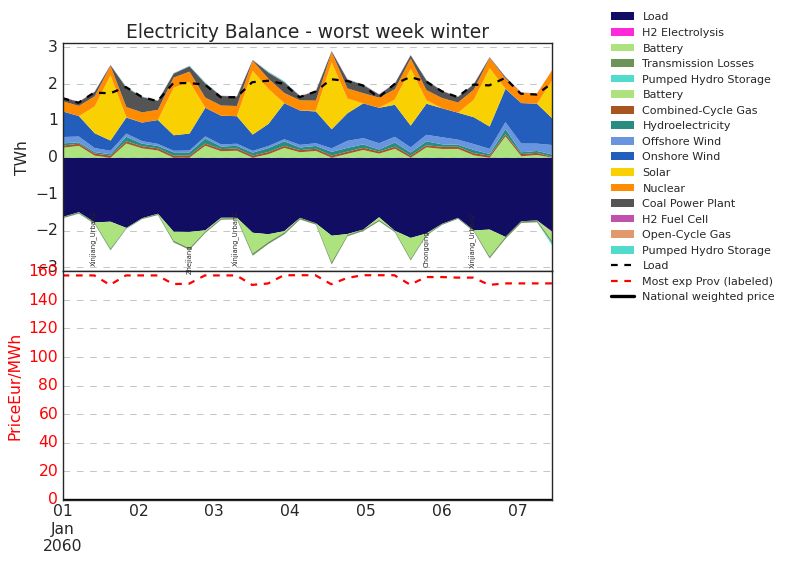

In [97]:
with io.capture_output() as captured:
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    ax0 = axes[0]
    plot_energy_balance(
        n,
        config["plotting"],
        start_date=str(winter_week[0]),
        end_date=str(winter_week[-1]),
        ax=axes[0],
    )
    ax0.grid(axis="y")
    ax0.set_title("Electricity Balance - worst week winter")
    ax2 = axes[1]
    peak_pr_provinces_hrs_winter[1].plot(
        ax=ax2, color="red", lw=2, ls="--", label="Most exp Prov (labeled)"
    )
    weighed_prices.loc[winter_week].plot(
        ax=ax2, color="k", lw=3, ls="-", label="National weighted price"
    )
    ax2.set_ylabel("PriceEur/MWh", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    # Move the existing legend to the right
    handles, labels = ax0.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    ax0.legend(
        handles + handles2,
        labels + labels2,
        loc="center left",
        bbox_to_anchor=(1.1, 0.5),
        fontsize=10,
    )
    fig.tight_layout()
    fig.subplots_adjust(hspace=0, wspace=10)


# annotate points in axis
i = 0
prev = ""
for idx, row in peak_pr_provinces_hrs_winter.iterrows():
    i += 1
    # if i%2==0:
    #     offset = -5*len(row[0])
    # else:
    offset = 10
    if i % 3 != 0:
        continue
    if row[0] == prev:
        continue
    ax2.annotate(
        row[0],
        xy=(idx, row[1]),
        textcoords="offset points",
        xytext=(0, offset),
        ha="center",
        fontsize=6,
        rotation=90,
    )
    prev = row[0]

ax2.set_xlabel("")

Text(0.5, 11.24444444444447, '')

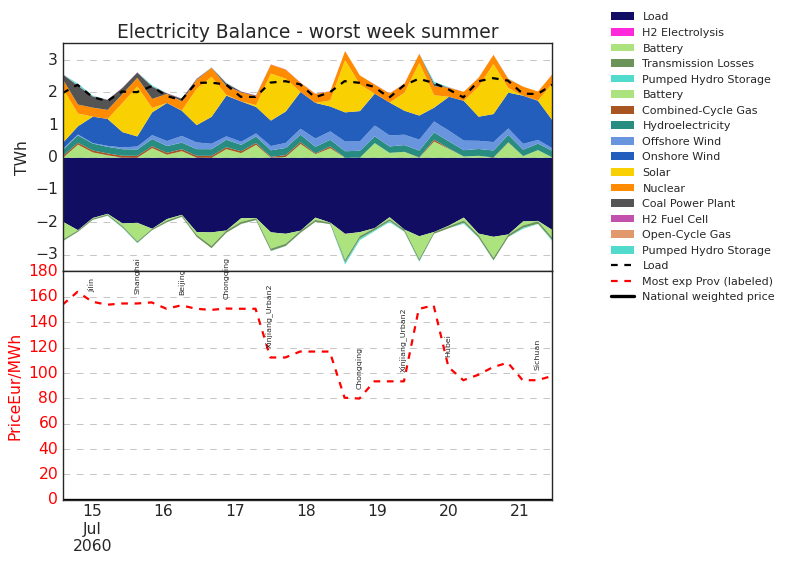

In [98]:
with io.capture_output() as captured:
    fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    ax0 = axes[0]
    plot_energy_balance(
        n,
        config["plotting"],
        start_date=str(summer_week[0]),
        end_date=str(summer_week[-1]),
        ax=axes[0],
    )
    ax0.grid(axis="y")
    ax0.set_title("Electricity Balance - worst week summer")
    ax2 = axes[1]
    peak_pr_provinces_hrs_summer[1].plot(
        ax=ax2, color="red", lw=2, ls="--", label="Most exp Prov (labeled)"
    )
    weighed_prices.loc[summer_week].plot(
        ax=ax2, color="k", lw=3, ls="-", label="National weighted price"
    )
    ax2.set_ylabel("PriceEur/MWh", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    # Move the existing legend to the right
    handles, labels = ax0.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    ax0.legend(
        handles + handles2,
        labels + labels2,
        loc="center left",
        bbox_to_anchor=(1.1, 0.5),
        fontsize=10,
    )
    fig.tight_layout()
    fig.subplots_adjust(hspace=0, wspace=10)


# annotate points in axis
i = 0
prev = ""
for idx, row in peak_pr_provinces_hrs_summer.iterrows():
    i += 1
    # if i%2==0:
    #     offset = -5*len(row[0])
    # else:
    offset = 10
    if i % 3 != 0:
        continue
    if row[0] == prev:
        continue
    ax2.annotate(
        row[0],
        xy=(idx, row[1]),
        textcoords="offset points",
        xytext=(0, offset),
        ha="center",
        fontsize=7,
        rotation=90,
    )
    prev = row[0]

ax2.set_xlabel("")

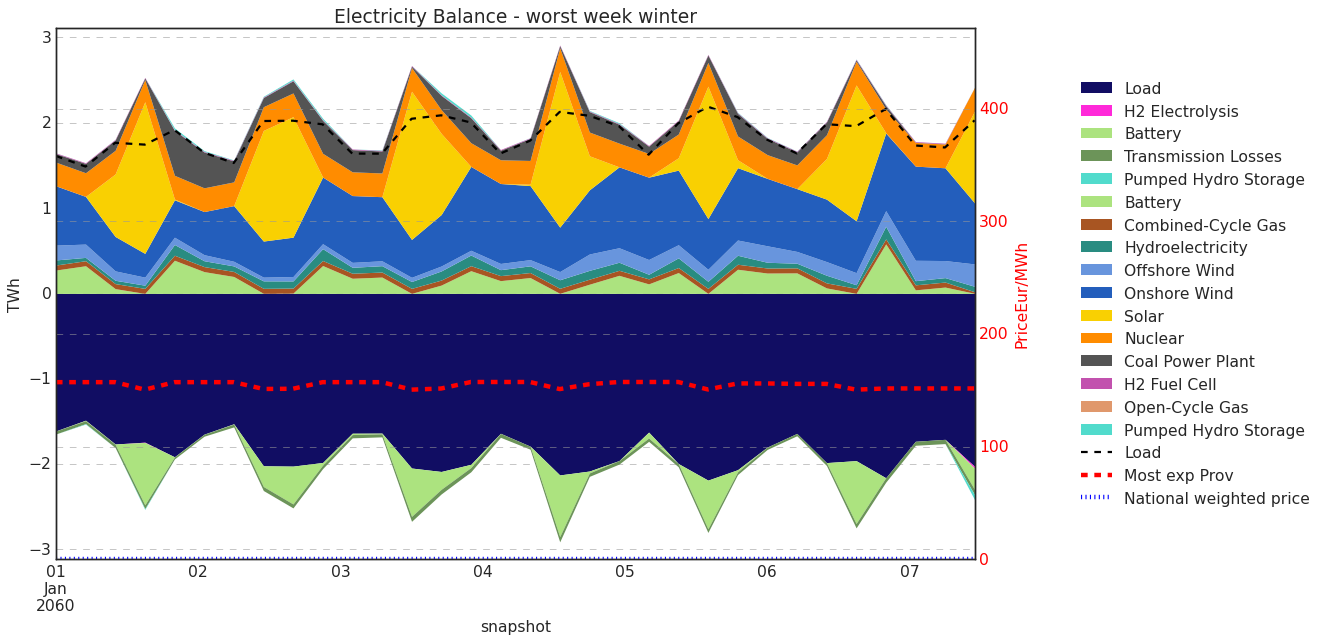

In [94]:
with io.capture_output() as captured:
    ax = plot_energy_balance(
        n,
        config["plotting"],
        start_date=str(winter_week[0]),
        end_date=str(winter_week[-1]),
    )
    ax.grid(axis="y")
    ax.set_title("Electricity Balance - worst week winter")
    ax2 = ax.twinx()
    prov_max_price_series.loc[winter_week].plot(
        ax=ax2, color="red", lw=4, ls="--", label="Most exp Prov"
    )
    weighed_prices.loc[winter_week].plot(
        ax=ax2, color="blue", lw=4, ls=":", label="National weighted price"
    )
    fig = ax.get_figure()
    ax2.set_ylabel("PriceEur/MWh", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.set_ylim([0, prov_max_price_series.loc[winter_week].max() * 3])
    # Move the existing legend to the right
    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(
        handles + handles2,
        labels + labels2,
        loc="center left",
        bbox_to_anchor=(1.1, 0.5),
    )

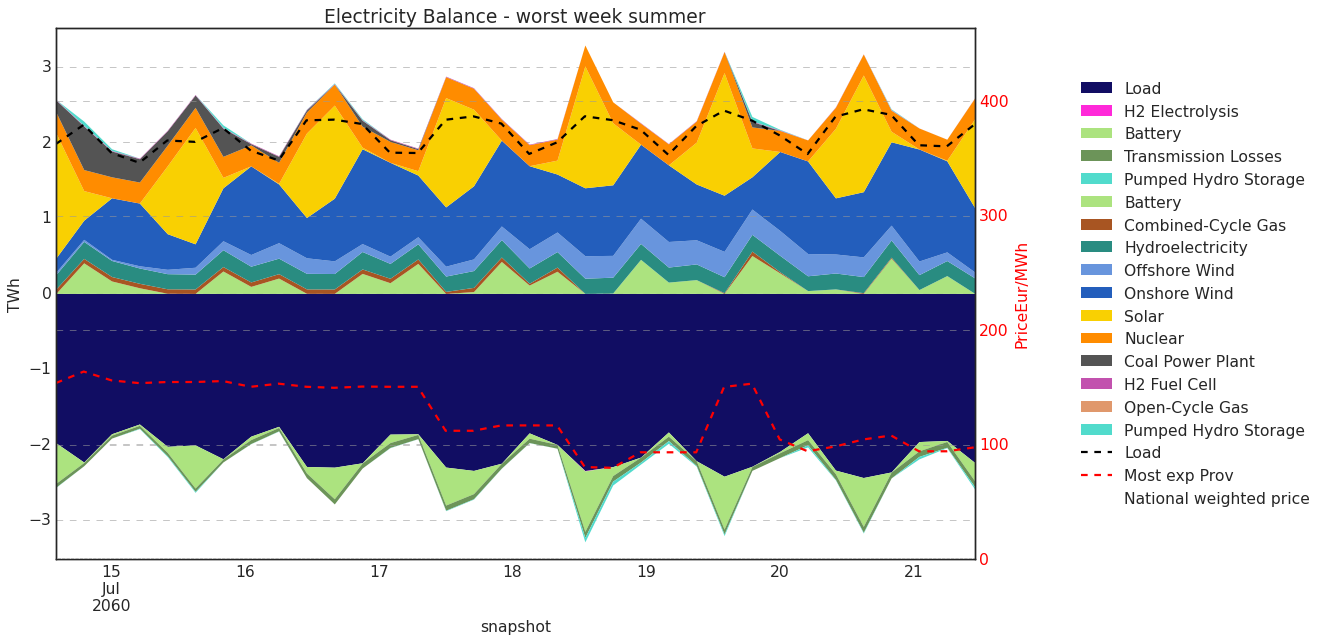

In [99]:
with io.capture_output() as captured:
    ax = plot_energy_balance(
        n,
        config["plotting"],
        start_date=str(summer_week[0]),
        end_date=str(summer_week[-1]),
    )
    ax.grid(axis="y")
    ax.set_title("Electricity Balance - worst week summer")
    ax2 = ax.twinx()
    prov_max_price_series.loc[summer_week].plot(
        ax=ax2, color="red", lw=2, ls="--", label="Most exp Prov"
    )
    weighed_prices.loc[summer_week].plot(
        ax=ax2, color="white", lw=3, ls=":", label="National weighted price"
    )
    fig = ax.get_figure()
    ax2.set_ylabel("PriceEur/MWh", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.set_ylim([0, prov_max_price_series.loc[winter_week].mean() * 3])
    # Move the existing legend to the right
    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(
        handles + handles2,
        labels + labels2,
        loc="center left",
        bbox_to_anchor=(1.1, 0.5),
    )

In [100]:
if snakemake.config["heat_coupling"]:
    ax = plot_energy_balance(
        n,
        config["plotting"],
        start_date=f"{PLANNING_YEAR}-03-31 21:00",
        end_date=f"{PLANNING_YEAR}-09-06 12:00:00",
        bus_carrier="heat",
    )
    ax.set_title("Heat balance")
    ax2 = ax.twinx()
    prov_max_price_series.loc[
        f"{PLANNING_YEAR}-03-31 21:00" : f"{PLANNING_YEAR}-09-06 12:00:00"
    ].plot(ax=ax2, color="red", lw=2, ls="--", label="Most exp Prov")
    weighed_prices.loc[
        f"{PLANNING_YEAR}-03-31 21:00" : f"{PLANNING_YEAR}-09-06 12:00:00"
    ].plot(ax=ax2, color="blue", lw=3, ls=":", label="National weighted price")
    prov_min_price_series.loc[
        f"{PLANNING_YEAR}-03-31 21:00" : f"{PLANNING_YEAR}-09-06 12:00:00"
    ].plot(ax=ax2, color="green", lw=2, ls="--", label="Least exp Prov")

    fig = ax.get_figure()
    ax2.set_ylabel("PriceEur/MWh", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    ax2.set_ylim(
        [
            0,
            prov_max_price_series.loc[
                f"{PLANNING_YEAR}-03-31 21:00" : f"{PLANNING_YEAR}-09-06 12:00:00"
            ].max()
            * 3,
        ]
    )
    # Move the existing legend to the right
    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(
        handles + handles2,
        labels + labels2,
        loc="center left",
        bbox_to_anchor=(1.1, 0.5),
    )

In [101]:
if snakemake.config["heat_coupling"]:
    ax = plot_energy_balance(
        n,
        config["plotting"],
        start_date=f"{PLANNING_YEAR}-01-01 00:00",
        end_date=f"{PLANNING_YEAR}-12-31 23:00:00",
        bus_carrier="heat",
    )
    ax.set_title("Heat balance")

In [102]:
from plot_time_series import (
    plot_load_duration_curve,
    plot_regional_load_durations,
    plot_residual_load_duration_curve,
)

# LOAD DURATION CURVES

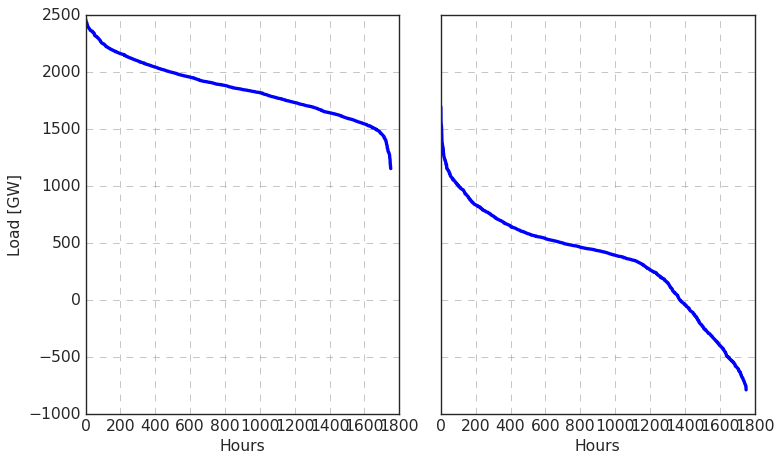

In [103]:
fig, ax = plt.subplots(1, 2, figsize=(10, 6), sharey=True)
plot_load_duration_curve(n, carrier="AC", ax=ax[0])
plot_residual_load_duration_curve(n, ax=ax[1])
fig.tight_layout()

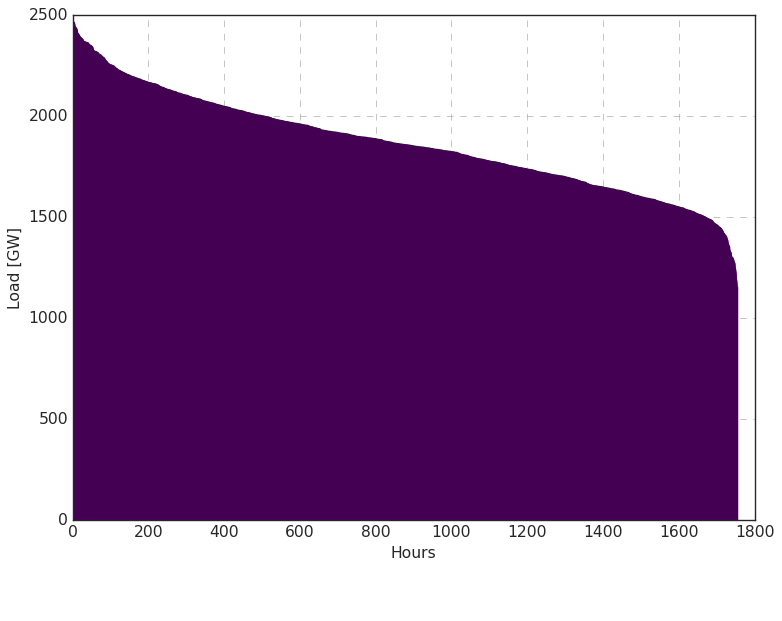

In [104]:
with io.capture_output() as captured:
    plot_regional_load_durations(n, carrier="AC", cmap="viridis")

## Power flows map

In [105]:
from _pypsa_helpers import get_location_and_carrier

transmission = (
    n.statistics.transmission(
        bus_carrier="AC",
        groupby=get_location_and_carrier,
        aggregate_time=False,
    )
    / 1e6
)  # # convert to TW
transm_tot = transmission.T.sum().reset_index()
transm_tot = (
    transm_tot.set_index("location")
    .rename(columns={0: "HV transmission"})
    .sort_values(by="HV transmission")
)
regi_transmission = transmission.groupby("location").sum().loc[transm_tot.index[::-1]]

/tmp/ipykernel_3712652/293440516.py:4: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



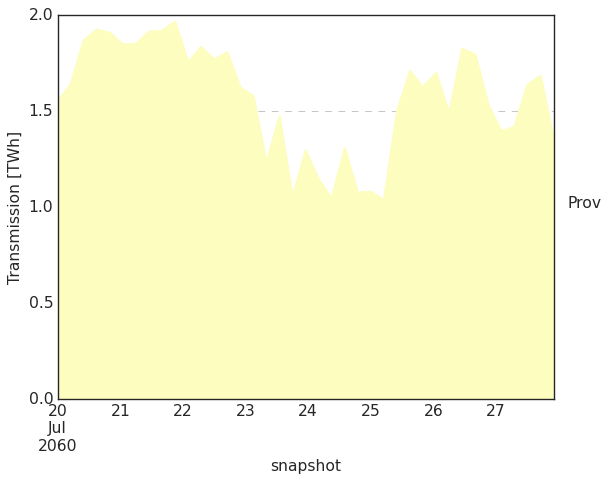

In [106]:
ax = regi_transmission.T.loc[
    f"{PLANNING_YEAR}-07-20" : f"{PLANNING_YEAR}-07-27"
].plot.area(stacked=True, cmap="magma_r")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Prov", ncols=2)
ax.set_ylabel("Transmission [TWh]");

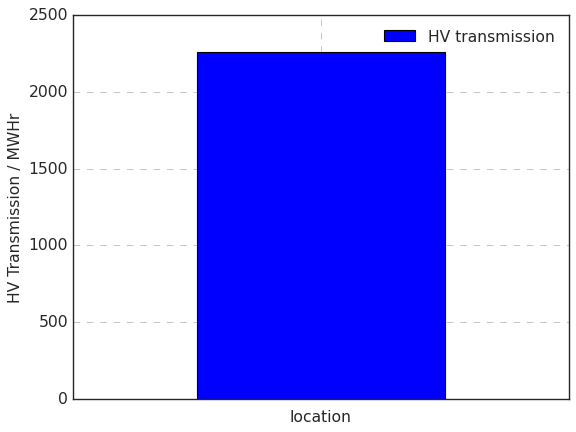

In [107]:
ax = transm_tot.plot.bar(y="HV transmission")
ax.set_ylabel("HV Transmission / MWHr");

### Plot cap factors time series

In [108]:
capacity_factors = (
    n.statistics.capacity_factor(aggregate_time=False).loc[["Generator"]].droplevel(0).T
)
colors_lowered = {
    k.lower().rstrip(): v for k, v in config["plotting"]["tech_colors"].items()
}
cap_colors = {
    k: colors_lowered.get(k.lower().rstrip(), "lightgrey")
    for k in [c for c in capacity_factors.columns]
}

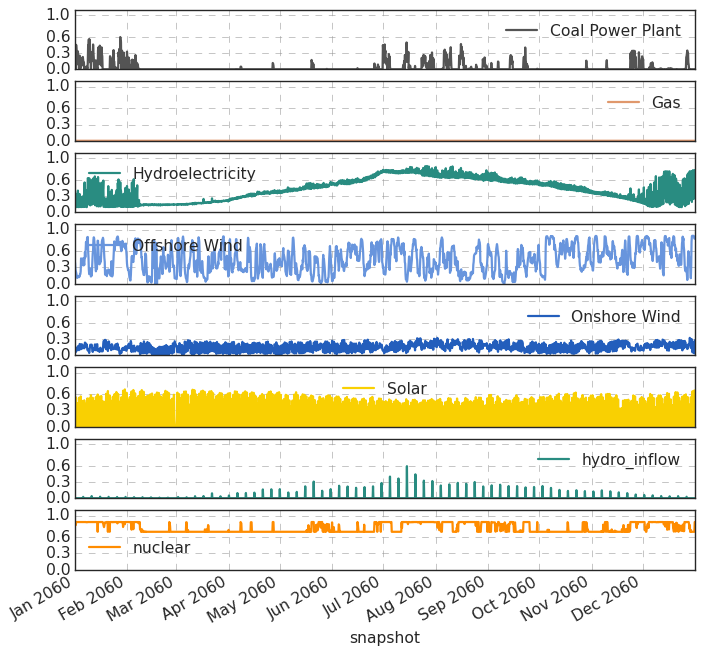

In [109]:
axes = (
    capacity_factors.dropna(axis=1, how="all")
    .fillna(0)
    .plot(subplots=True, figsize=(10, 10), color=cap_colors)
)
for ax in axes:
    ax.set_ylim([0, 1.1])
    ax.set_yticks([0, 0.3, 0.6, 1])

In [116]:
ac_mask = n.buses.query("carrier=='AC'").index
n.buses.loc[ac_mask, "location"] = ac_mask

In [117]:
location_grouper = "location" # or province
region_rev = n.statistics.revenue(
    groupby=[location_grouper, "carrier"], bus_carrier="AC", aggregate_time=False
).fillna(0)
rev_regional = region_rev[(region_rev < 0).all(axis=1)].groupby(location_grouper).sum().T
weighting = n.snapshot_weightings.iloc[0, 0]
prod_reg = (
    n.statistics.energy_balance(
        comps=["Load", "Link", "Generator"],
        groupby=[location_grouper, "carrier"],
        bus_carrier="AC",
        aggregate_time=False,
    )
    * weighting
)
prod_reg = prod_reg.fillna(0)
consum_regional = prod_reg.query("component=='Load'").groupby(location_grouper).sum().T
balance = prod_reg.groupby(location_grouper).sum().T
supp_regional = prod_reg.query("component!='Load'").groupby(location_grouper).sum().T

In [119]:
prod_reg

snapshot                              2060-01-01 00:00:00  \
component location  carrier                                 
Load      Anhui     -                       -303410.77610   
          Beijing   -                       -111006.89025   
          Chongqing -                       -120306.76675   
          Fujian    -                       -204737.87380   
          Gansu     -                       -155774.04915   
...                                                   ...   
Generator Zhejiang  Hydroelectricity           6344.14360   
                    Offshore Wind            364272.82030   
                    Onshore Wind               4165.79415   
                    Solar                         0.00000   
                    nuclear                   39982.60185   

snapshot                              2060-01-01 05:00:00  \
component location  carrier                                 
Load      Anhui     -                       -286518.05490   
          Beijing   -                       -106247.72545   
          Chongqing -                       -102985.97795   
          Fujian    -                       -178917.65710   
          Gansu     -                       -146696.46405   
...                                                   ...   
Generator Zhejiang  Hydroelectricity           5941.83020   
                    Offshore Wind            312836.99830   
                    Onshore Wind               4580.53610   
                    Solar                         0.00000   
                    nuclear                   39982.60175   

snapshot                              2060-01-01 10:00:00  \
component location  carrier                                 
Load      Anhui     -                       -309090.43780   
          Beijing   -                       -129865.23200   
          Chongqing -                       -163031.71660   
          Fujian    -                       -249776.98485   
          Gansu     -                       -166350.82360   
...                                                   ...   
Generator Zhejiang  Hydroelectricity           5986.37870   
                    Offshore Wind            126966.42015   
                    Onshore Wind               2726.22340   
                    Solar                     22519.82460   
                    nuclear                   39982.60170   

snapshot                              2060-01-01 15:00:00  \
component location  carrier                                 
Load      Anhui     -                       -315751.33790   
          Beijing   -                       -125810.73630   
          Chongqing -                       -155597.48145   
          Fujian    -                       -245388.38600   
          Gansu     -                       -164224.27135   
...                                                   ...   
Generator Zhejiang  Hydroelectricity           5557.57100   
                    Offshore Wind             79143.40450   
                    Onshore Wind               3509.24450   
                    Solar                     21270.35620   
                    nuclear                   39982.60160   

snapshot                              2060-01-01 20:00:00  \
component location  carrier                                 
Load      Anhui     -                       -381041.14445   
          Beijing   -                       -137359.06955   
          Chongqing -                       -172702.00220   
          Fujian    -                       -263418.03500   
          Gansu     -                       -177746.66140   
...                                                   ...   
Generator Zhejiang  Hydroelectricity          19891.75360   
                    Offshore Wind             76926.37460   
                    Onshore Wind              17344.13865   
                    Solar                         0.00000   
                    nuclear                   39982.60345   

snapshot                      

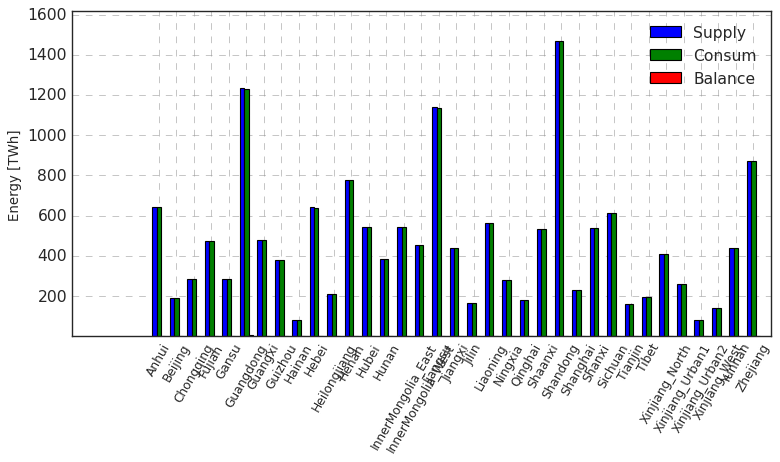

In [118]:
data = pd.concat(
    [supp_regional.sum(), -1 * consum_regional.sum(), balance.sum()], axis=1
)
data.columns = ["Supply", "Consum", "Balance"]
data = data.query("index != ''")  # no location assigned
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25
x = np.arange(len(data.index))
data = data / 1e6
ax.bar(x - bar_width, data["Supply"], width=bar_width, label="Supply")
ax.bar(x, data["Consum"], width=bar_width, label="Consum")
ax.bar(x + bar_width, data["Balance"], width=bar_width, label="Balance")

ax.set_xticks(x)
ax.set_xticklabels(data.index, rotation=60, horizontalalignment="center", fontsize=11)
ax.legend()
ax.set_ylabel("Energy [TWh]", fontsize=12)
ax.set_ylim(data.min().min(), data.max().max() * 1.1)
fig.tight_layout()
plt.show()

In [ ]:
max_val = max(supp_regional.max().max(), -1 * consum_regional.max().max())

norm_price = n.buses_t["marginal_price"][PROV_NAMES].loc[
    f"{PLANNING_YEAR}-07-22" : f"{PLANNING_YEAR}-07-28"
]
norm_price /= norm_price.max()
norm_price *= (consum_regional * -1e-6).loc[
    f"{PLANNING_YEAR}-07-22" : f"{PLANNING_YEAR}-07-28"
].max().max() * 0.8
consum_regional = consum_regional[PROV_NAMES]

In [ ]:
def plot_sufficience_panels(consum_regional, supp_regional):
    fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(20, 20))
    for i, c in enumerate(consum_regional.columns):
        k, l = (i + 4) // 6, (i + 4) % 6
        (consum_regional[c] * -1e-3).loc[
            f"{PLANNING_YEAR}-07-22" : f"{PLANNING_YEAR}-07-28"
        ].plot(ax=axes[k, l])
        (supp_regional[c] * 1e-3).loc[
            f"{PLANNING_YEAR}-07-22" : f"{PLANNING_YEAR}-07-28"
        ].plot(ax=axes[k, l], color="orange", alpha=0.5)
        axes[k, l].set_title(c)
        axes[k, l].set_ylim(0, max_val * 1e-3)

        if l == 0:
            axes[k, l].set_ylabel("Withdrawal or supply [GWh]")
        if k == 0:
            axes[k, l].set_xlabel("Time")
    axes[0, 4].legend(["Withdrawal (blue)", "Supply (orange)"])
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.15, wspace=0.1)


def plot_exports_panels(exports_regional, norm_price):
    fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(20, 20))

    for i, c in enumerate(exports_regional.columns):
        k, l = (i + 4) // 6, (i + 4) % 6
        exports = (exports_regional[c] * 1e-3).loc[
            f"{PLANNING_YEAR}-12-22" : f"{PLANNING_YEAR}-12-28"
        ]
        exports.plot(ax=axes[k, l], color="orange", alpha=1)
        if c in norm_price.columns:
            norm_price[c].plot(
                ax=axes[k, l], color="green", alpha=0.5, legend=False, ls="--"
            )

        axes[k, l].set_title(c)
        # axes[k,l].set_ylim( exports.min(), exports.max())
        axes[k, l].axhline(0, color="black", lw=1)
        if l == 0:
            axes[k, l].set_ylabel("Balance [GWh] \n Norm Price (green)")
        if k == 0:
            axes[k, l].set_xlabel("Time")
    axes[0, 4].legend(["Exports"])
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.2, wspace=0.1)

In [ ]:
PLOT_VIGNETTES = False
if PLOT_VIGNETTES:
    plot_sufficience_panels(consum_regional, supp_regional)

In [ ]:
exports_regional = balance
max_val = balance.max().max()
norm_price = n.buses_t["marginal_price"][PROV_NAMES].loc[
    f"{PLANNING_YEAR}-12-22" : f"{PLANNING_YEAR}-12-28"
]
norm_price /= norm_price.max()
norm_price *= max_val * 0.3e-3

In [ ]:
if PLOT_VIGNETTES:
    plot_exports_panels(exports_regional, norm_price)

# Capacity factors

In [ ]:
colors_lowered = {
    k.lower().rstrip(): v for k, v in config["plotting"]["tech_colors"].items()
}
cap_colors = {
    k: colors_lowered.get(k.lower().rstrip(), "lightgrey")
    for k in [c for c in capacity_factors.columns]
}

# Apply rolling moving average filter
capacity_factors_smoothed = capacity_factors.rolling(window="1D", min_periods=1).mean()

axes = (
    capacity_factors_smoothed.dropna(axis=1, how="all")
    .fillna(0)
    .plot(subplots=True, figsize=(10, 12), color=cap_colors)
)
for ax in axes:
    ax.set_ylim([0, 1.1])
    ax.set_yticks([0, 0.3, 0.6, 1])
axes[3].set_ylabel("Capacity Factor (1D average)")

# COSTS & prices

## Price duration curve


In [ ]:
n.buses.carrier[n.buses.carrier=="H2"].index.values

In [ ]:
n.buses.carrier[n.buses.carrier == "H2"].index.values

In [ ]:
PLOT_VRE_HEAT_MAPS = False

if PLOT_VRE_HEAT_MAPS:
    vres = ["offwind", "onwind", "solar"]
    vre_avail = (
        n.statistics.supply(
            comps="Generator",
            aggregate_time=False,
            bus_carrier="AC",
            nice_names=False,
            groupby=["location", "carrier"],
        )
        .query("carrier in @vres")
        .T.fillna(0)
    )

    for tech in vres:
        tech_avail = vre_avail.T.query("carrier == @tech").T.droplevel(1, axis=1)
        tech_avail.index = tech_avail.index.strftime("%m-%d %H:%M")

        fig, ax = plt.subplots()
        sns.heatmap(tech_avail, ax=ax, cbar_kws={"label": "Availability [MW]"})
        ax.set_title(f"{tech} availability")

In [ ]:
if PLOT_VRE_HEAT_MAPS:
    vres = ["offwind", "onwind", "solar"]
    available_p_u = (
        (n.generators_t.p_max_pu * n.generators.p_nom_opt)
        .fillna(0)
        .T.groupby([n.generators.location, n.generators.carrier])
        .sum()
        .T
    )
    available_p_u /= (
        n.generators.p_nom_opt.fillna(0)
        .T.groupby([n.generators.location, n.generators.carrier])
        .sum()
    )
    available_p_u = available_p_u.T.query("carrier in @vres")

    for tech in vres:
        tech_avail = available_p_u.query("carrier == @tech").T.droplevel(1, axis=1)
        tech_avail = tech_avail.loc[winter_week]
        tech_avail.index = tech_avail.index.strftime("%m-%d %H:%M")

        fig, ax = plt.subplots()
        sns.heatmap(tech_avail, ax=ax, cbar_kws={"label": "Availability [p.u.]"})
        ax.set_title(f"{tech} availability")

In [ ]:
PLOT_PRICE_DETAILS = False
if PLOT_PRICE_DETAILS:
    plot_price_heatmap(n, "AC", log_values=True, time_range=summer_week)
    plot_price_duration_by_node(n, carrier="AC", logy=False)
    plot_price_duration_by_node(n, carrier="AC")
    plot_price_duration_by_node(
        n, carrier="H2", logy=False, fig_shape=(8, 4), y_lower=0
    )

In [ ]:
from plot_summary_all import plot_prices

paths = [
    os.path.join(results_dir, "summary", f"ntwk_{yr}")
    for yr in snakemake.config["scenario"]["planning_horizons"]
]
data_paths = {
    "energy": [os.path.join(p, "energy.csv") for p in paths],
    "costs": [os.path.join(p, "costs.csv") for p in paths],
    "co2_price": [os.path.join(p, "metrics.csv") for p in paths],
    "time_averaged_prices": [
        os.path.join(p, "time_averaged_prices.csv") for p in paths
    ],
    "weighted_prices": [os.path.join(p, "weighted_prices.csv") for p in paths],
    "co2_balance": [os.path.join(p, "co2_balance.csv") for p in paths],
    "energy_supply": [os.path.join(p, "supply_energy.csv") for p in paths],
    "capacity": [os.path.join(p, "capacities.csv") for p in paths],
}

fig, ax = plt.subplots()
plot_prices(
    data_paths["time_averaged_prices"], config["plotting"], fig_name=None, ax=ax, lw=4
)

fig, ax = plt.subplots()
plot_prices(
    data_paths["weighted_prices"], config["plotting"], fig_name=None, ax=ax, lw=3
)

# ax.semilogy()

In [ ]:
stores_inflow = n.stores_t.p.sum()
h2_stores = stores_inflow.loc[
    [c for c in stores_inflow.index if c.find("H2 Store") != -1]
]
h2_stores_inflow = h2_stores.where(h2_stores > 0, 0).sum()
h2_stores_outflow = h2_stores.where(h2_stores < 0, 0).sum()

# STATS

In [ ]:
reg_groups = pd.read_csv(
    os.path.join(root_dir, "resources/data/regions/province_grid_groups.csv")
)
reg_groups.set_index("Province", inplace=True)
mapper = reg_groups["Region"].to_dict()
gen = n.statistics.supply(
    comps=["Generator", "Link"], groupby=["carrier", "location"], bus_carrier="AC"
)

demands_prov = n.statistics.withdrawal(
    comps="Load",
    groupby=["location"],
    bus_carrier="AC",
)
grid_demands = demands_prov.groupby(mapper).sum()
grid_demands.index = grid_demands.index.str.replace("China Grid", "").str.replace(
    "Grid", ""
)

In [ ]:
gen_df = gen.unstack().groupby(level=1).sum().rename(columns={"": "no_loc"})
if "no_loc" in gen_df.columns:
    gen_df.drop(columns=["no_loc"])
gen_df.drop("AC", inplace=True)
# gen_df = gen_df.T
# gen_df = gen_df.groupby(mapper).sum().T / 1E6
gen_df = gen_df / 1e6
gen_df.rename(
    columns={
        c.replace("China Grid", "").replace("Grid", ""): c for c in gen_df.columns
    },
    inplace=True,
)
demands = demands_prov / 1e6

pref_order = config["plotting"]["preferred_order"]
order = [c for c in pref_order if c in gen_df.index] + [
    c for c in gen_df.index if c not in pref_order
]
gen_df = gen_df.loc[order]
colors = gen_df.index.map(config["plotting"]["tech_colors"])
colors = dict(zip(gen_df.index, colors))
ax = gen_df.T.plot.bar(
    stacked=True,
    color=[colors.get(carrier, "lightgrey") for carrier in gen_df.index],
    figsize=(8, 6),
)
demands.plot(lw=0, marker="D", c="k", markersize=8, label="Demand\n", ax=ax)
ax.legend(
    loc="center left", bbox_to_anchor=(1, 0.5), title="Carrier", ncol=1, fontsize=8
)
ax.set_ylim([0, gen_df.sum().max() * 1.1])
ax.set_ylabel("Generation [TWh]")
ax.set_xlabel("Province")
# Offset tick labels to the right for better alignment
# for label in ax.get_xticklabels():
#     label.set_x(label.get_position()[0] -3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=11);

In [ ]:
gen_df = gen.unstack().groupby(level=1).sum().rename(columns={"": "no_loc"})
if "no_loc" in gen_df.columns:
    gen_df.drop(columns=["no_loc"])
gen_df.drop("AC", inplace=True)
gen_df = gen_df.T
gen_df = gen_df.groupby(mapper).sum().T / 1e6
gen_df.rename(
    columns={
        c.replace("China Grid", "").replace("Grid", ""): c for c in gen_df.columns
    },
    inplace=True,
)
demands = grid_demands / 1e6

pref_order = config["plotting"]["preferred_order"]
order = [c for c in pref_order if c in gen_df.index] + [
    c for c in gen_df.index if c not in pref_order
]
gen_df = gen_df.loc[order]
colors = gen_df.index.map(config["plotting"]["tech_colors"])
colors = dict(zip(gen_df.index, colors))
ax = gen_df.T.plot.bar(
    stacked=True,
    color=[colors.get(carrier, "lightgrey") for carrier in gen_df.index],
    figsize=(8, 6),
)
demands.plot(lw=0, marker="D", c="k", markersize=16, label="Demand\n", ax=ax)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Carrier", ncol=2)
ax.set_ylim([0, gen_df.sum().max() * 1.1])
ax.set_ylabel("Generation [TWh]")
ax.set_xlabel("Grid")
# Offset tick labels to the right for better alignment
# for label in ax.get_xticklabels():
#     label.set_x(label.get_position()[0] -3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

In [ ]:
peak_load = n.statistics.withdrawal(
    comps="Load", groupby=["location"], bus_carrier="AC", aggregate_time=False
).T.max()

In [ ]:
cap = n.statistics.optimal_capacity(
    comps=["Generator", "Link"], groupby=["carrier", "location"], bus_carrier="AC"
)

cap_df = cap.unstack().groupby(level=1).sum().rename(columns={"": "no_loc"})
if "no_loc" in cap_df.columns:
    cap_df.drop(columns=["no_loc"])
cap_df.drop("AC", inplace=True)
# cap_df = cap_df.T
# cap_df = cap_df.groupby(mapper).sum().T / 1E6
cap_df = cap_df / 1e3
cap_df.rename(
    columns={
        c.replace("China Grid", "").replace("Grid", ""): c for c in cap_df.columns
    },
    inplace=True,
)
peak_demand = peak_load / 1e3

pref_order = config["plotting"]["preferred_order"]
order = [c for c in pref_order if c in cap_df.index] + [
    c for c in cap_df.index if c not in pref_order
]
cap_df = cap_df.loc[order]
colors = cap_df.index.map(config["plotting"]["tech_colors"])
colors = dict(zip(cap_df.index, colors))
ax = cap_df.T.plot.bar(
    stacked=True,
    color=[colors.get(carrier, "lightgrey") for carrier in cap_df.index],
    figsize=(8, 6),
)
peak_demand.plot(lw=0, marker="D", c="k", markersize=8, label="Peak Load\n", ax=ax)
ax.legend(
    loc="center left", bbox_to_anchor=(1, 0.5), title="Carrier", ncol=1, fontsize=8
)
ax.set_ylim([0, cap_df.sum().max() * 1.2])
ax.set_ylabel("Capacity [GW]")
ax.set_xlabel("Province")
# Offset tick labels to the right for better alignment
# for label in ax.get_xticklabels():
#     label.set_x(label.get_position()[0] -3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center", fontsize=11);

In [ ]:
def get_solver_tolerance(config: dict, tol_name="BarConvTol") -> float:
    """Get the solver tolerance from the config

    Args:
        config (dict): the config
        tol_name (str): the name of the tolerance option. Defaults to "BarConvTol"

    Returns:
        float: the value
    """
    solver_opts = config["solving"]["solver"]["options"]
    return config["solving"]["solver_options"][solver_opts][tol_name]


def find_numerical_zeros(n, config, tolerance_name="BarConvTol") -> list:
    """
    Identify numerical zeros in the network's optimization results.

    This function checks for numerical zeros in the network's optimization results,
    such as link capacities or weighted prices, based on a specified solver tolerance.

    Args:
        n (pypsa.Network): The PyPSA network object containing optimization results.
        config (dict): Configuration dictionary containing solver options.
        tolerance_name (str): The name of the solver tolerance option to use. Defaults to "BarConvTol".

    Returns:
        list: A list of items (e.g., links or buses) where numerical zeros are detected.
    """
    tol = get_solver_tolerance(config, tolerance_name)
    threshold = n.objective * float(tol)

    costs = pd.concat([n.statistics.expanded_capex(), n.statistics.opex()], axis=1)
    return costs.fillna(0).sum(axis=1).loc[costs.sum(axis=1) < threshold].index


num_zeros = find_numerical_zeros(n, config, tolerance_name="BarConvTol")

In [ ]:
PLOT_STATS = False


def rename_index(ds):
    specific = ds.index.map(lambda x: f"{x[1]}\n({x[0]})")
    generic = ds.index.get_level_values("carrier")
    duplicated = generic.duplicated(keep=False)
    index = specific.where(duplicated, generic)
    return ds.set_axis(index)


def plot_static_per_carrier(ds, ax, drop_zero=True):
    if drop_zero:
        ds = ds[ds != 0]
    ds = ds.dropna()
    c = colors[ds.index.get_level_values("carrier")]
    ds = ds.pipe(rename_index)
    label = f"{ds.attrs['name']} [{ds.attrs['unit']}]"
    ds.plot.barh(color=c.values, xlabel=label, ax=ax)
    ax.grid(axis="y")


if PLOT_STATS:
    bus_carrier = "AC"
    n.loads.carrier = "load"
    n.carriers.loc["load", ["nice_name", "color"]] = "Load", "#110d63"
    colors = n.carriers.set_index("nice_name").color.where(
        lambda s: s != "", "lightgrey"
    )

    fig, ax = plt.subplots()
    ds = n.statistics.capacity_factor(bus_carrier=bus_carrier).dropna()
    plot_static_per_carrier(ds, ax)
    plt.show()

    fig, ax = plt.subplots()
    ds = n.statistics.installed_capacity(bus_carrier=bus_carrier).dropna()
    if "Line" in ds.index:
        ds = ds.drop("Line")
    ds = ds.drop(("Generator", "Load"), errors="ignore")
    ds = ds / 1e3
    ds.attrs["unit"] = "GW"
    plot_static_per_carrier(ds.abs(), ax)
    plt.show()

    fig, ax = plt.subplots()
    ds = n.statistics.optimal_capacity(bus_carrier=bus_carrier)
    if "Line" in ds.index:
        ds = ds.drop("Line")
    ds = ds.drop(("Generator", "Load"), errors="ignore")
    ds = ds.abs() / 1e3
    ds.attrs["unit"] = "GW"
    plot_static_per_carrier(ds, ax)
    plt.show()

    fig, ax = plt.subplots()
    ds = n.statistics.capex(bus_carrier=bus_carrier)
    plot_static_per_carrier(ds, ax)
    plt.show()

    fig, ax = plt.subplots()
    ds = n.statistics.opex(bus_carrier=bus_carrier)
    plot_static_per_carrier(ds, ax)
    plt.show()

    fig, ax = plt.subplots()
    ds = n.statistics.curtailment(bus_carrier=bus_carrier)
    plot_static_per_carrier(ds, ax)
    plt.show()

    fig, ax = plt.subplots()
    ds = n.statistics.supply(bus_carrier=bus_carrier)
    if "Line" in ds.index:
        ds = ds.drop("Line")
    ds = ds / 1e6
    ds.attrs["unit"] = "TWh"
    plot_static_per_carrier(ds, ax)
    plt.show()

    if snakemake.config["heat_coupling"]:
        fig, ax = plt.subplots()
        ds = n.statistics.supply(bus_carrier="heat")
        if "Line" in ds.index:
            ds = ds.drop("Line")
        ds = ds / 1e6
        ds.attrs["unit"] = "TWh"
        plot_static_per_carrier(ds, ax)
        plt.show()

    fig, ax = plt.subplots()
    ds = n.statistics.withdrawal(bus_carrier=bus_carrier)
    if "Line" in ds.index:
        ds = ds.drop("Line")
    ds = ds / -1e6
    ds.attrs["unit"] = "TWh"
    plot_static_per_carrier(ds, ax)
    plt.show()

    fig, ax = plt.subplots()
    ds = n.statistics.market_value(bus_carrier=bus_carrier)
    plot_static_per_carrier(ds, ax)
    plt.show()

In [ ]:
from _pypsa_helpers import calc_lcoe
rev_costs = calc_lcoe(n, groupby=None)
rev_costs


In [ ]:
with io.capture_output() as captured:
    ds = rev_costs["LCOE"].droplevel(0)
    ds.attrs = {"name": "LCOE", "unit": "€/MWh"}
    fig, ax = plt.subplots()
    plot_static_per_carrier(ds[~ds.index.isin(num_zeros)], ax)

    ds = rev_costs["profit_pu"]
    ds.attrs = {"name": "MV - LCOE", "unit": "€/MWh"}
    fig, ax = plt.subplots()
    plot_static_per_carrier(ds[~ds.index.isin(num_zeros)], ax)

# Network topology
irrelevant as don't have lines

In [ ]:
n.determine_network_topology()
n.sub_networks["n_branches"] = [len(sn.branches()) for sn in n.sub_networks.obj]
n.sub_networks["n_buses"] = [len(sn.buses()) for sn in n.sub_networks.obj]

# Shadow prices

In [ ]:
import seaborn as sns

In [ ]:
capex_ = n.statistics.expanded_capex().sum()
installed_capex_ = n.statistics.installed_capex().sum()
opex_ = n.statistics.opex().sum()
costs_ = pd.DataFrame(
    {
        "OPEX": opex_,
        "Installed CAPEX": installed_capex_,
        "CAPEX": capex_,
        "total": capex_ + installed_capex_ + opex_,
    },
    index=["Costs"],
).stack()
revenue_ = n.statistics.revenue(comps="Load", bus_carrier="AC").sum()
costs_.loc[("Revenue", "AC")] = revenue_ * -1
all_ = pd.concat({f"{PLANNING_YEAR} budget": costs_}, names=["CO2 control"])
all_.index.names = ["CO2 control", "Cat", "Type"]
all_ = pd.DataFrame(all_, columns=["Value"])


sns.catplot(
    all_,
    x="Cat",
    y="Value",
    hue="Type",
    col="CO2 control",
    dodge=True,
    kind="bar",
    alpha=0.8,
)

In [ ]:
rev = n.statistics.revenue(groupby=pypsa.statistics.get_carrier_and_bus_carrier)
opex = n.statistics.opex(groupby=pypsa.statistics.get_carrier_and_bus_carrier)
capex = n.statistics.expanded_capex(
    groupby=pypsa.statistics.get_carrier_and_bus_carrier
)
supply = n.statistics.supply(groupby=pypsa.statistics.get_carrier_and_bus_carrier)
index = rev.index.union(opex.index).union(capex.index)
rents = pd.concat(
    [opex, capex, rev, supply], axis=1, keys=["OPEX", "CAPEX", "Revenue", "supply"]
).fillna(0)
rents["delta"] = rents.apply(lambda row: row.Revenue - row.CAPEX - row.OPEX, axis=1)
rents["delta_pu"] = rents.delta / rents.supply
rents.sort_values("delta_pu", ascending=False, inplace=True)

In [ ]:
rents[rents.supply > 1e5].droplevel(0).sort_values(
    "delta_pu", ascending=False
).plot.bar(y="delta_pu", stacked=True, figsize=(10, 6), ylabel="Rev-Costs Eur/MWh");

In [ ]:
npresolve = pypsa.Network(
    "/p/tmp/ivanra/PyPSA-China-PIK/results/v-1.1.0_REMIND_EFC_2025-07-21_r27_more_windbins_freeze/overnight_co2pw-SSP2-PkBudg1000-CHA-higher_minwind_cf_topo-current+FCG/prenetworks-brownfield/ntwk_2055.nc"
)

## INTERACTIVE

In [ ]:
import numpy as np

# make names and link sizes, make sure we only plot AC, DC & statiosn
ac_links = n.links[n.links.carrier == "AC"]
colors = n.links.index.to_series().apply(lambda x: "black" if "ext" in x else "pink")
widths = np.log(n.links.p_nom_opt + 3) / 2
widths[~widths.index.isin(ac_links.index)] = 0
widths[widths.index.str.contains("reversed")] = 0
names = n.links.copy()
names["name"] = names.index.values
names.loc[~names.index.isin(ac_links.index), "p_nom_opt"] = ""
names.loc[~names.index.isin(ac_links.index), "name"] = ""
buses = n.buses.copy()
buses["name"] = buses.apply(
    lambda x: f"{x.name}" if x.carrier == "AC" or x.carrier == "stations" else "",
    axis=1,
)
buses["sizes"] = buses.apply(
    lambda x: 10 if x.carrier == "AC" or x.carrier == "stations" else 0, axis=1
)
buses["colors"] = buses.apply(lambda x: "black" if x.carrier == "AC" else "red", axis=1)
buses.carrier.unique()
ax = n.iplot(
    link_colors=colors,
    link_widths=widths,
    link_text=names.p_nom_opt.astype(str) + names.name,
    bus_text=buses.name,
    bus_sizes=buses.sizes,
    bus_colors=buses.colors,
);

# EXAMPLES

In [ ]:
import geopandas as gpd

In [ ]:
vre_techs = ["onwind", "offwind", "solar"]
resources = {}
for tech in vre_techs:
    nbins = config["renewable"][tech]["resource_classes"]["n"]
    min_cf = config["renewable"][tech]["resource_classes"]["min_cf_delta"]
    target = os.path.join(
        root_dir,
        f"resources/derived_data/cutout_China-2020c/{tech}_regions_by_class_min_cf_delta{min_cf}_n{nbins}.geojson",
    )
    resources[tech] = gpd.read_file(target)

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
# Adjust colorbar to fit the subplot height

divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=-0.3)
resources["solar"].plot("cf", cmap="magma_r", legend=True, edgecolor=None, linewidth=0, ax=ax[0], cax=cax)
resources["solar"].dissolve("bus").boundary.plot(edgecolor="white", facecolor="none", linewidth=0.7, ax=ax[0])
ax[0].set_title("Solar PV Availability Factor")

divider2 = make_axes_locatable(ax[1])
cax2 = divider2.append_axes("right", size="5%", pad=-0.3)

resources["onwind"][resources["onwind"].cf > 0.02].plot(
    "cf",
    cmap="magma_r",
    legend=True,
    linewidth=0,
    ax=ax[1],
    cax=cax2,
    vmin=0.05,
    missing_kwds={"color": "white"},
)
resources["offwind"][resources["offwind"].cf > 0.05].plot(
    "cf",
    cmap="magma_r",
    legend=True,
    linewidth=0,
    ax=ax[1],
    cax=cax2,
    vmin=0.05,
    alpha=0.8,
    missing_kwds={"color": "white"},
)
resources["onwind"].dissolve("bus").boundary.plot(
    edgecolor="black", facecolor=None, linewidth=0.7, ax=ax[1]
)
ax[1].set_title("Wind Availability Factor")
fig.tight_layout()